## Imports


In [2]:
!pip install ucimlrepo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import os
from ucimlrepo import fetch_ucirepo


# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')

## Load Dataset

In [4]:
def load_data():
    """Load dataset and perform initial preprocessing"""

    print("Loading Appliances Energy Prediction dataset from UCI Repository...")

    # Fetch dataset
    appliances_energy_prediction = fetch_ucirepo(id=374)

    # Get data as pandas dataframes
    X = appliances_energy_prediction.data.features
    y = appliances_energy_prediction.data.targets

    # Show metadata
    print("\nDataset metadata:")
    print(appliances_energy_prediction.metadata)

    # Information about variables
    print("\nVariable information:")
    print(appliances_energy_prediction.variables)

    # Combine features and target into a single DataFrame
    df = pd.concat([X, y], axis=1)

    # Convert index to datetime using 'date' column
    if 'date' in df.columns:
        # Specify exact date string format
        try:
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d%H:%M:%S')
        except ValueError as e:
            print(f"Error trying to convert 'date' with format '%Y-%m-%d%H:%M:%S': {e}")
            print("Trying to infer format...")
            # Fallback to infer format if explicit format fails
            df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce')

        df = df.set_index('date')


    print("\nDataFrame loaded successfully!")
    print("First 5 rows of DataFrame:")
    print(df.head())

    # Check missing values
    print(f"\nMissing values per column:")
    print(df.isnull().sum())

    # Preencher valores ausentes se necessário
    if df.isnull().sum().sum() > 0:
        print("Preenchendo valores ausentes...")
        df.ffill(inplace=True)  # Preenche NaNs com o valor anterior válido
        df.bfill(inplace=True)  # Preenche NaNs restantes (no início do DF) com o valor seguinte válido

    # Adicionar features de tempo se o índice é datetime
    # Verificar explicitamente se o índice é um DatetimeIndex após a conversão
    if isinstance(df.index, pd.DatetimeIndex):
        print("Adicionando features baseadas em tempo...")
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek  # Segunda=0, Domingo=6
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        try:
            # isocalendar().week é mais robusto, mas pode ter problemas com datas do início/fim do ano
            df['weekofyear'] = df.index.isocalendar().week.astype(int)
        except Exception as e:
            print(f"Erro ao tentar usar isocalendar().week: {e}. Tentando .week...")
            # Alternativa para versões mais antigas do pandas ou casos de borda
            df['weekofyear'] = df.index.week  # Esta pode ser ambígua em torno da virada do ano

    print("\nDataFrame com novas features:")
    print(df.head())

    return df

In [5]:
df = carregar_dados()

Carregando dataset Appliances Energy Prediction da UCI Repository...

Metadados do dataset:
{'uci_id': 374, 'name': 'Appliances Energy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/374/data.csv', 'abstract': 'Experimental data used to create regression models of appliances energy use in a low energy building.', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 19735, 'num_features': 28, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Appliances'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2017, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5VC8G', 'creators': ['Luis Candanedo'], 'intro_paper': {'ID': 398, 'type': 'NATIVE', 'title': 'Data driven prediction models of energy use of appliances in a low-energy house',

## Pre processing and Features


In [6]:
def preparar_series_temporais(df, target='Appliances', janela=24, previsao=1):
    """
    Converte os dados para formato de séries temporais para uso em RNN
    janela: número de timesteps anteriores para usar como input
    previsao: número de timesteps à frente para prever
    """
    print(f"\nPreparando séries temporais com janela={janela} e previsão={previsao}")

    # Verificar se a coluna target existe
    if target not in df.columns:
        print(f"ATENÇÃO: Coluna target '{target}' não encontrada. Colunas disponíveis: {df.columns.tolist()}")
        return None, None, None, None, None, None, None, None

    # Filtrando colunas numéricas (excluindo o target)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if target in numeric_cols:
        numeric_cols.remove(target)

    # Seleção das features (todas colunas numéricas exceto o target)
    features_disponiveis = numeric_cols

    print(f"\nFeatures utilizadas ({len(features_disponiveis)}):")
    print(features_disponiveis)
    print(f"Target: {target}")

    # Criar dataset para a RNN
    X_data = df[features_disponiveis].values
    y_data = df[target].values

    # Normalizar dados
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_scaled = X_scaler.fit_transform(X_data)
    y_scaled = y_scaler.fit_transform(y_data.reshape(-1, 1))

    # Preparar sequências para RNN
    X_sequencias = []
    y_sequencias = []

    for i in range(len(X_scaled) - janela - previsao + 1):
        X_sequencias.append(X_scaled[i:i+janela])
        y_sequencias.append(y_scaled[i+janela:i+janela+previsao])

    X_sequencias = np.array(X_sequencias)
    y_sequencias = np.array(y_sequencias)

    print(f"Formato das sequências X: {X_sequencias.shape}")
    print(f"Formato das sequências y: {y_sequencias.shape}")

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequencias, y_sequencias, test_size=0.2, random_state=42, shuffle=False
    )

    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test, X_scaler, y_scaler, df.index, features_disponiveis

In [7]:
X_train, X_test, y_train, y_test, X_scaler, y_scaler, indices, features = preparar_series_temporais(df, target='Appliances')


Preparando séries temporais com janela=24 e previsão=1

Features utilizadas (28):
['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'weekofyear']
Target: Appliances
Formato das sequências X: (19711, 24, 28)
Formato das sequências y: (19711, 1, 1)
X_train: (15768, 24, 28), y_train: (15768, 1, 1)
X_test: (3943, 24, 28), y_test: (3943, 1, 1)


In [8]:
def visualizar_dados(df, target='Appliances'):
    """Cria visualizações exploratórias dos dados"""
    print("\nCriando visualizações exploratórias...")

    # Verificar se a coluna target existe
    if target not in df.columns:
        print(f"ATENÇÃO: Coluna target '{target}' não encontrada. Colunas disponíveis: {df.columns.tolist()}")
        return False

    # Visualização 1: Série temporal do consumo de energia
    plt.figure(figsize=(15, 5))
    plot_data = df[target].tail(5000) if len(df) > 5000 else df[target]
    plot_data.plot(title=f'Consumo de Energia {target} ao Longo do Tempo')
    plt.ylabel(f'{target} (Wh)')
    plt.xlabel('Tempo')
    plt.show()

    # Se temos features de tempo
    if 'hour' in df.columns:
        # Visualização 2: Distribuição por hora
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='hour', y=target)
        plt.title(f'Distribuição de {target} por Hora do Dia')
        plt.show()

    if 'month' in df.columns:
        # Visualização 3: Distribuição por mês
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='month', y=target)
        plt.title(f'Distribuição de {target} por Mês')
        plt.show()

    # Visualização 4: Histograma do consumo de energia
    plt.figure(figsize=(12, 6))
    sns.histplot(df[target], kde=True)
    plt.title(f'Distribuição do Consumo de Energia {target}')
    plt.xlabel(f'{target} (Wh)')
    plt.show()

    # Visualização 5: Correlação entre features
    plt.figure(figsize=(14, 10))

    # Selecionar colunas numéricas para a matriz de correlação
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Limitar a 20 colunas se houver muitas para melhor visualização
    if len(numeric_columns) > 20:
        # Garantir que o target está incluído
        top_correlations = df[numeric_columns].corr()[target].abs().sort_values(ascending=False)
        top_features = top_correlations.index[:19].tolist()  # Top 19 + target = 20
        if target not in top_features:
            top_features.append(target)
        numeric_columns = top_features

    # Criar matriz de correlação
    correlation_matrix = df[numeric_columns].corr()

    # Visualizar matriz de correlação
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
    plt.title('Matriz de Correlação entre Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualização 6: Pairplot com features mais importantes
    important_features = [target]

    # Adicionar features com maior correlação absoluta com o target
    if len(numeric_columns) > 3:  # Só fazemos isso se tivermos várias colunas
        top_corr = df[numeric_columns].corr()[target].abs().sort_values(ascending=False)
        for feature in top_corr.index[:5]:  # Top 5 features
            if feature != target:
                important_features.append(feature)

    if len(important_features) > 1:  # Só criar se tivermos mais de uma feature
        print("\nCriando pairplot das features mais importantes (pode demorar um pouco)...")
        sns.pairplot(df[important_features])
        plt.show()

    print("\nVisualizações criadas com sucesso!")
    return True


Criando visualizações exploratórias...


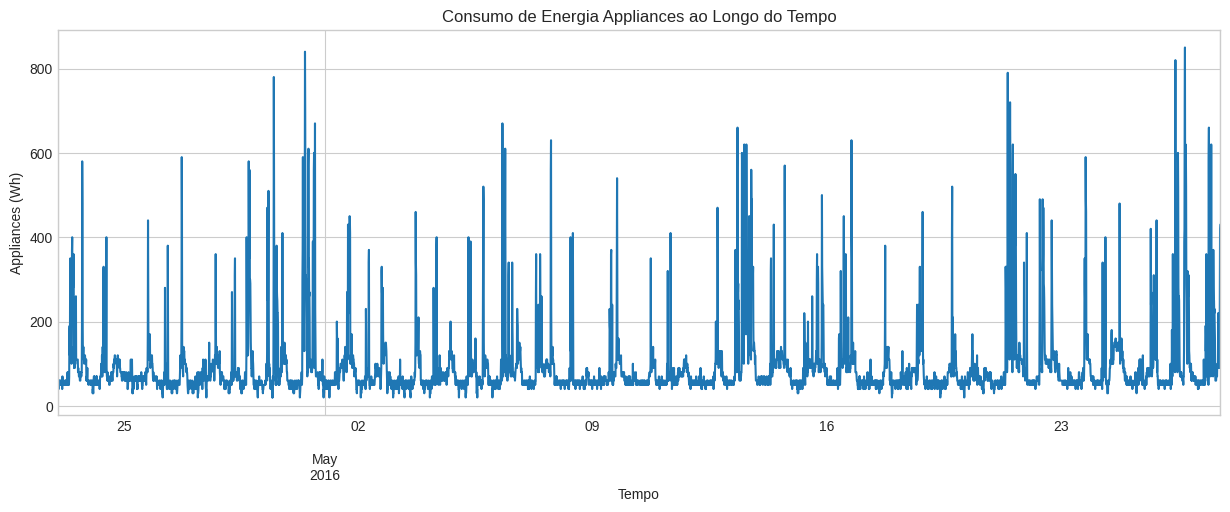

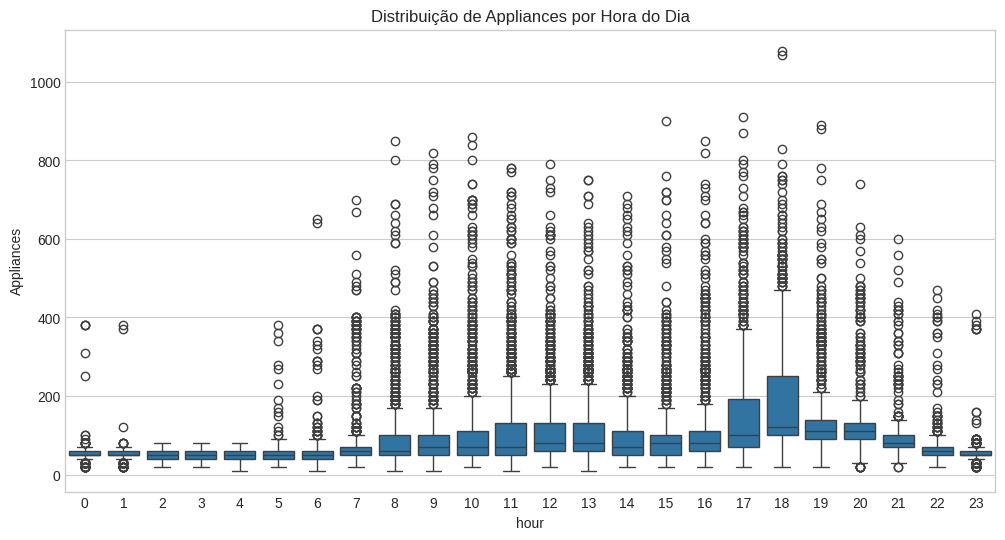

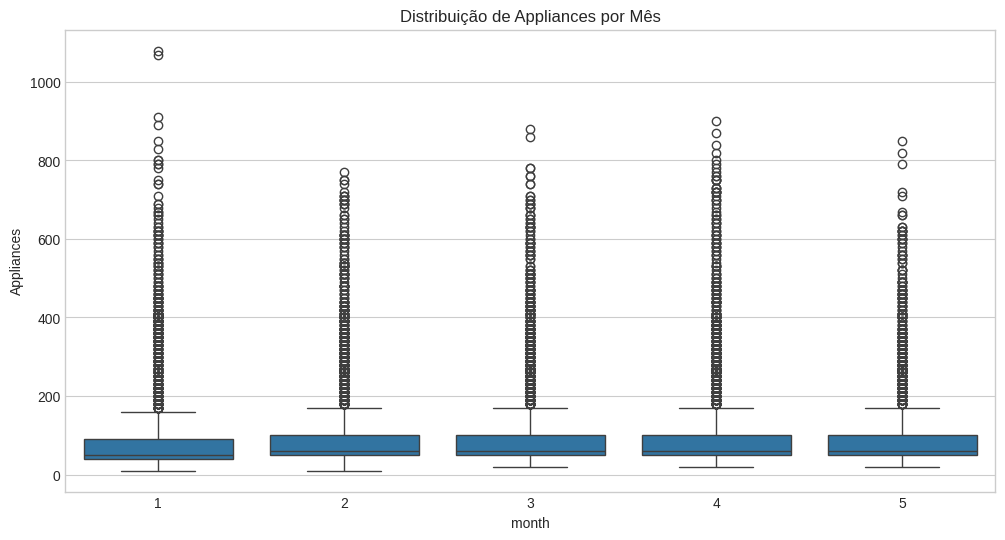

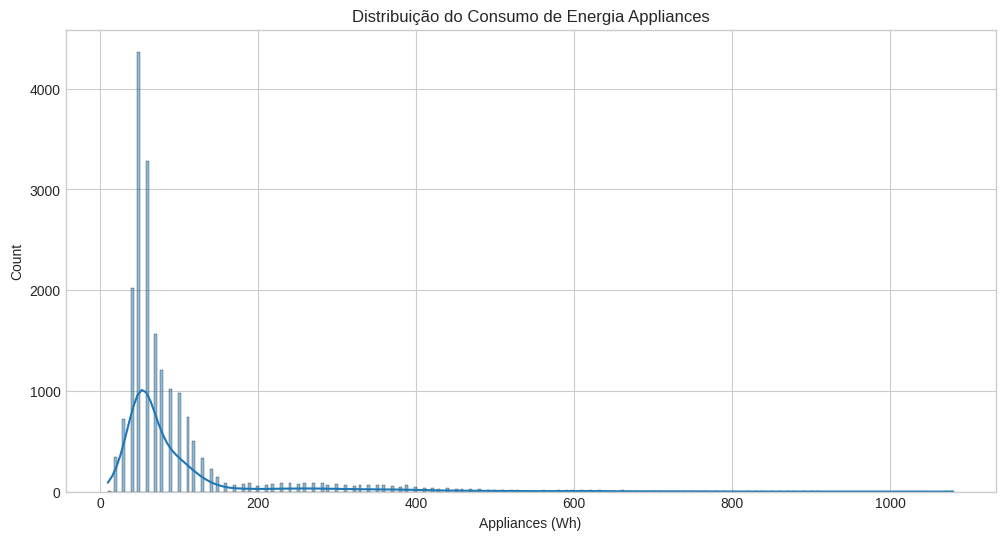

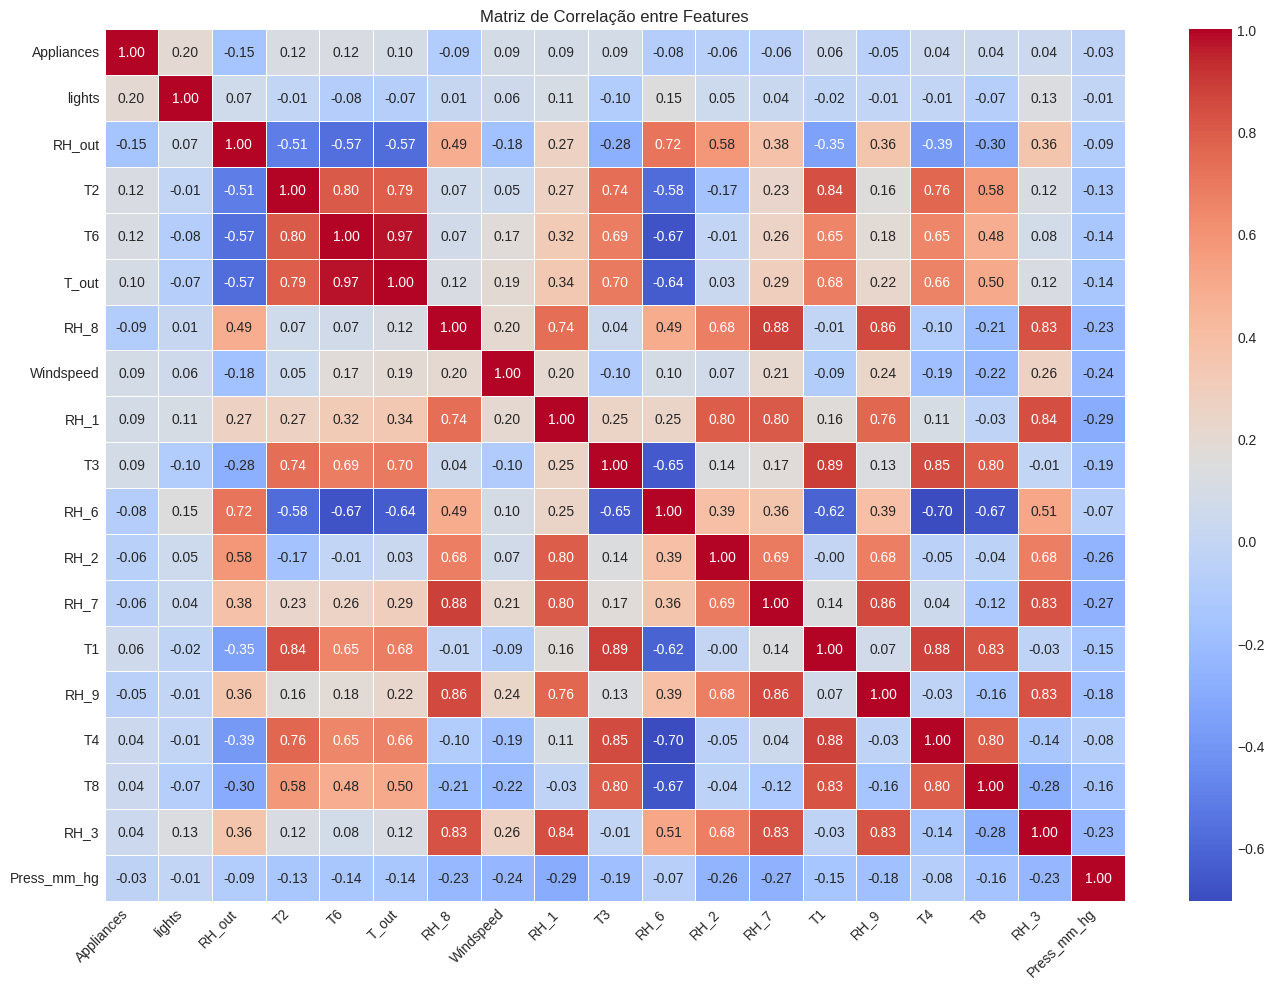


Criando pairplot das features mais importantes (pode demorar um pouco)...


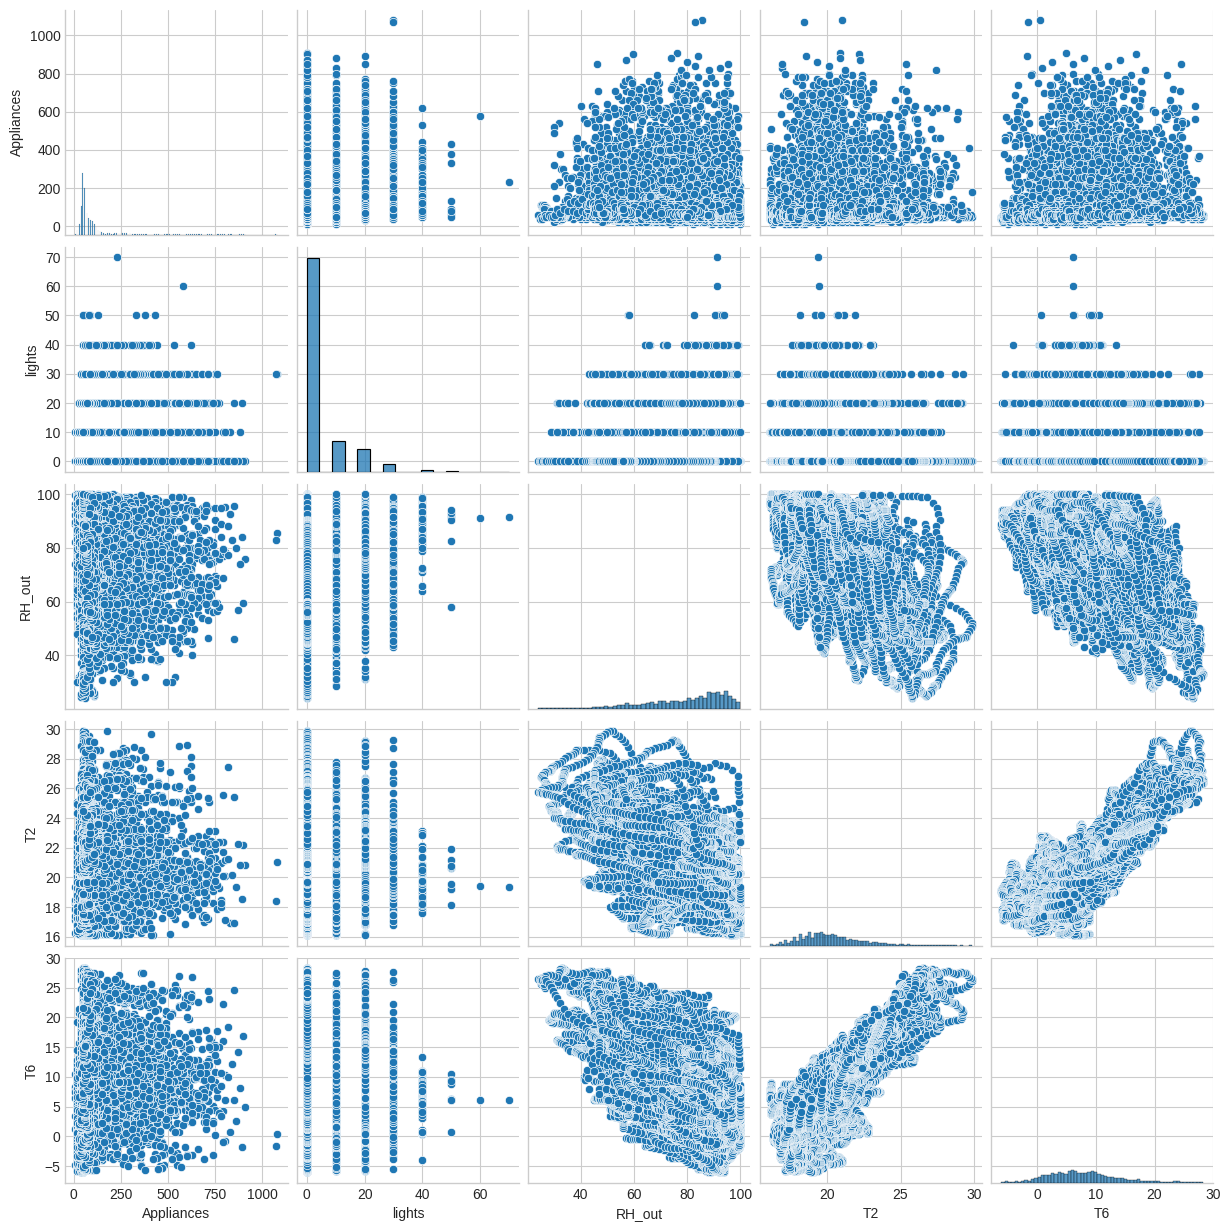


Visualizações criadas com sucesso!


True

In [9]:
visualizar_dados(df, target='Appliances')

## Create and Training Model

In [192]:
np.random.seed(42)
torch.manual_seed(42)

# Configurações globais
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 150
HIDDEN_SIZE_1 = 128
HIDDEN_SIZE_2 = 32
STACKED_LAYERS = 2
DROPOUT_PROB = 0.5

class SimpleBayesianLSTM(nn.Module):
    def __init__(self, n_features, output_length):
        super(SimpleBayesianLSTM, self).__init__()

        # Hiperparâmetros simplificados
        self.hidden_size = 64
        self.dropout_rate = 0.3

        # Camadas do modelo
        self.lstm = nn.LSTM(input_size=n_features,
                           hidden_size=self.hidden_size,
                           num_layers=1,
                           batch_first=True)

        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc = nn.Linear(self.hidden_size, output_length)

    def forward(self, x):
        # Passa pela LSTM
        lstm_out, _ = self.lstm(x)

        # Pega apenas o último output da sequência
        last_output = lstm_out[:, -1, :]

        # Aplica dropout (para aproximação Bayesiana)
        dropped = self.dropout(last_output)

        # Camada final
        output = self.fc(dropped)
        return output

    def predict(self, X):
        """Método para fazer previsões"""
        self.eval()  # Coloca o modelo em modo de avaliação
        with torch.no_grad():
            # Garante que X está no DEVICE correto
            if isinstance(X, np.ndarray):
                X = torch.FloatTensor(X).to(DEVICE)
            else: # Assume X is already a PyTorch tensor
                X = X.to(DEVICE)

            # Faz a previsão
            y_pred = self(X)

            # Retorna para CPU e converte para numpy
            return y_pred.cpu().numpy()

def criar_modelo_lstm(input_shape, output_shape=1):
    """Cria um modelo LSTM Bayesiano simplificado para a previsão de série temporal"""
    print("\nCriando modelo LSTM Bayesiano simplificado...")

    # Extrai número de features do input_shape
    if len(input_shape) == 3:
        n_features = input_shape[2]
    elif len(input_shape) == 2:
        n_features = input_shape[1]
    else:
        raise ValueError(f"Input shape inválido: {input_shape}")

    # Cria o modelo
    model = SimpleBayesianLSTM(n_features=n_features,
                              output_length=output_shape)
    model = model.to(DEVICE)

    print("\nArquitetura do modelo:")
    print(model)
    print(f"\nParâmetros do modelo:")
    print(f"- Número de features: {n_features}")
    print(f"- Tamanho da saída: {output_shape}")
    print(f"- Dispositivo: {DEVICE}")

    return model



In [193]:
# Criar modelo
input_shape = (X_train.shape[1], X_train.shape[2])
model = criar_modelo_lstm(input_shape=input_shape, output_shape=1)



Criando modelo LSTM Bayesiano simplificado...

Arquitetura do modelo:
SimpleBayesianLSTM(
  (lstm): LSTM(28, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Parâmetros do modelo:
- Número de features: 28
- Tamanho da saída: 1
- Dispositivo: cuda:0


In [194]:
def treinar_modelo(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=64, learning_rate=0.001):
    """Treina o modelo LSTM Bayesiano simplificado"""
    print("\nTreinando o modelo LSTM Bayesiano...")

    try:
        # Converter dados para tensores PyTorch
        X_train = torch.FloatTensor(X_train).to(DEVICE)
        y_train = torch.FloatTensor(y_train).to(DEVICE)
        X_test = torch.FloatTensor(X_test).to(DEVICE)
        y_test = torch.FloatTensor(y_test).to(DEVICE)

        # Otimizador e função de perda
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Histórico de treinamento
        history = {'loss': [], 'val_loss': []}

        # Loop de treinamento
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            n_batches = 0

            # Training loop
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i+batch_size]
                batch_y = y_train[i:i+batch_size]

                if len(batch_X) < batch_size:
                    continue

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                n_batches += 1

            avg_loss = total_loss / n_batches if n_batches > 0 else float('inf')
            history['loss'].append(avg_loss)

            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test)
                val_loss = criterion(val_outputs, y_test)
                history['val_loss'].append(val_loss.item())

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}')

        return model, history

    except Exception as e:
        print(f"\nERRO durante o treinamento: {str(e)}")
        raise e

In [195]:
model, historico = treinar_modelo(model, X_train, y_train, X_test, y_test)


Treinando o modelo LSTM Bayesiano...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3943, 1, 1])) that is different to the input size (torch.Size([3943, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0096, Val Loss: 0.0081
Epoch [20/100], Loss: 0.0094, Val Loss: 0.0082
Epoch [30/100], Loss: 0.0093, Val Loss: 0.0089
Epoch [40/100], Loss: 0.0092, Val Loss: 0.0097
Epoch [50/100], Loss: 0.0091, Val Loss: 0.0134
Epoch [60/100], Loss: 0.0090, Val Loss: 0.0160
Epoch [70/100], Loss: 0.0089, Val Loss: 0.0157
Epoch [80/100], Loss: 0.0089, Val Loss: 0.0091
Epoch [90/100], Loss: 0.0089, Val Loss: 0.0094
Epoch [100/100], Loss: 0.0089, Val Loss: 0.0083


# Avaliação do Modelo e Plotagem


In [196]:
def avaliar_modelo(model, X_test, y_test, y_scaler):
    """Avalia o modelo e mostra métricas absolutas e percentuais"""
    print("\nAvaliando o modelo no conjunto de teste...")

    # Converter para tensores PyTorch na GPU se ainda não for
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.FloatTensor(X_test).cuda()
    elif X_test.device.type == 'cpu':
        X_test = X_test.cuda()

    if not isinstance(y_test, torch.Tensor):
        y_test = torch.FloatTensor(y_test).cuda()
    elif y_test.device.type == 'cpu':
        y_test = y_test.cuda()

    # Fazer previsões
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test)

    # Mover para CPU e converter para numpy
    y_pred_scaled = y_pred_scaled.cpu().numpy()
    y_test = y_test.cpu().numpy()

    # Reverter normalização
    y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_original = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Calcular métricas
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    print(f"\nMétricas:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return y_test_original, y_pred_original

In [197]:
y_test_orig, y_pred_orig = avaliar_modelo(model, X_test, y_test, y_scaler)


Avaliando o modelo no conjunto de teste...

Métricas:
MSE: 7760.7285
MAE: 58.6942
RMSE: 88.0950
MAPE: 73.88%


In [198]:
def plotar_resultados(y_test, y_pred, historico, indices_teste, target='Appliances'):
    """Visualiza os resultados do modelo"""
    print("\nCriando visualizações dos resultados...")

    # Plot 1: Previsões vs. Valores Reais
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Real', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Previsão', color='red', alpha=0.7)
    plt.title(f'Previsão vs. Valores Reais de Consumo de Energia ({target})')
    plt.xlabel('Amostras')
    plt.ylabel(f'{target} (Wh)')
    plt.legend()
    plt.show()

    # Plot 2: Scatter Plot Valores Reais vs Previstos
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(f'Dispersão: Valores Reais vs. Previstos ({target})')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.show()

    print("\nVisualizações dos resultados criadas com sucesso!")



Criando visualizações dos resultados...


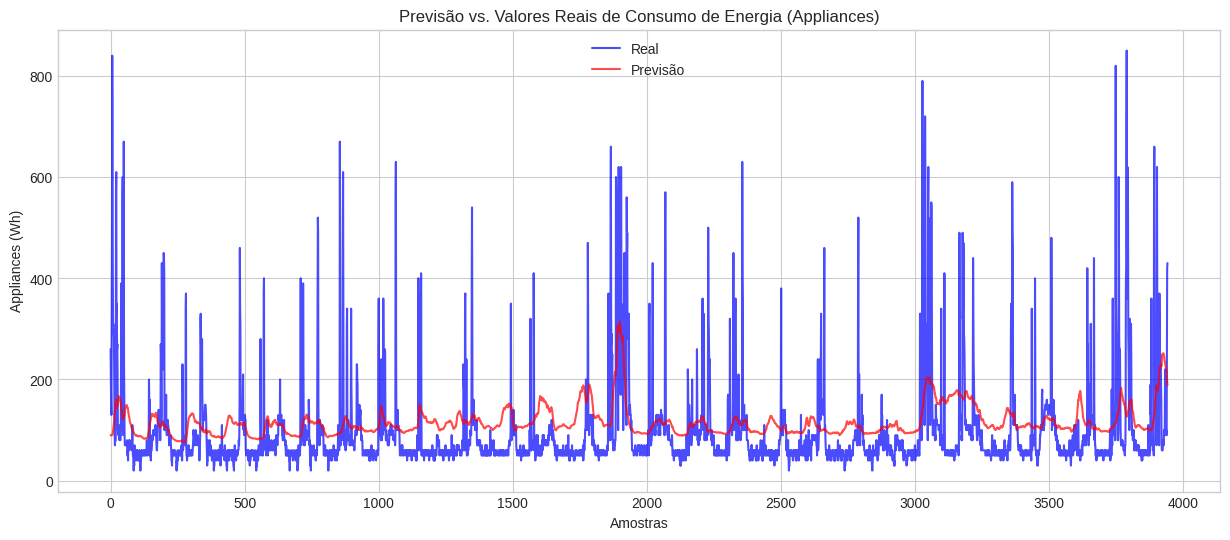

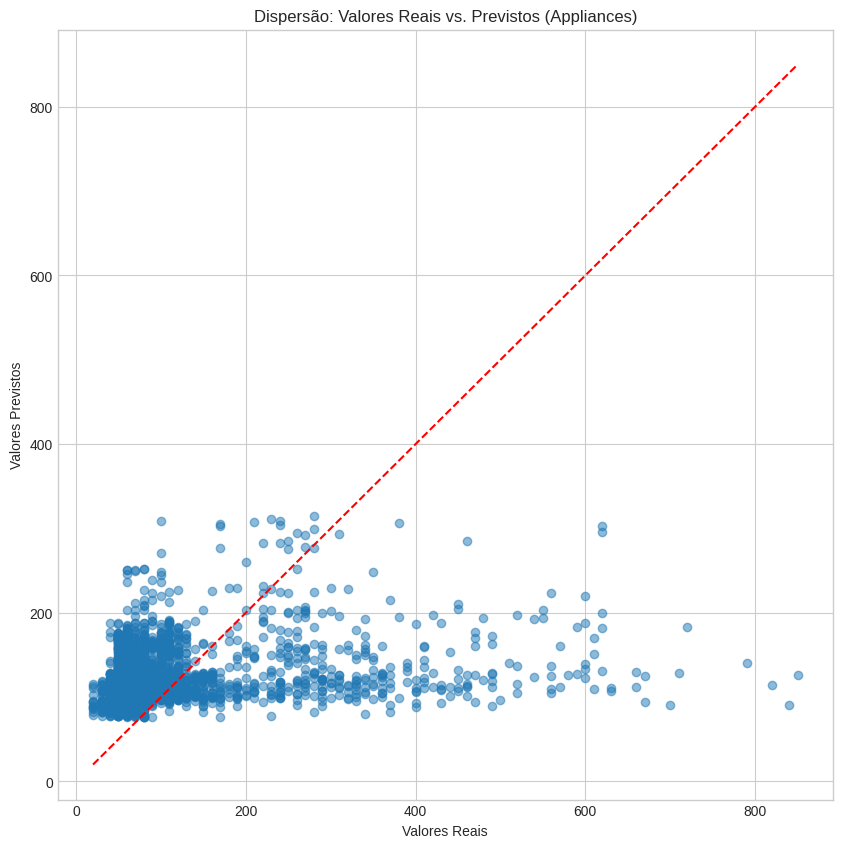


Visualizações dos resultados criadas com sucesso!


In [199]:
plotar_resultados(y_test_orig, y_pred_orig, historico, indices, target='Appliances')

## Previsões Futuras

In [230]:
def fazer_previsoes_futuras(model, df, features, X_scaler, y_scaler, target='ActivePower'):
    """Faz previsões para as próximas 24 horas"""
    print("\nFazendo previsões para as próximas 24 horas...")

    try:
        # Parâmetros fixos para previsão diária
        janela = 24  # Usa as últimas 24 horas como entrada
        n_previsoes = 24 * 60  # 24 horas * 60 minutos = 1440 previsões

        # Preparar última sequência conhecida
        ultimos_dados = df[features].values[-janela:]
        ultimos_dados_scaled = X_scaler.transform(ultimos_dados)

        # Pegar o último valor conhecido para garantir continuidade
        ultimo_valor_conhecido = df[target].iloc[-1]

        # Lista para armazenar previsões
        previsoes_scaled = []

        # Fazer previsões sequenciais
        sequencia_atual = ultimos_dados_scaled.copy()

        # Primeira previsão deve ser próxima ao último valor conhecido
        X = sequencia_atual.reshape(1, janela, -1)
        primeira_previsao = model.predict(X)
        previsao_original = y_scaler.inverse_transform(primeira_previsao.reshape(-1, 1))[0][0]

        # Calcular fator de ajuste para suavizar a transição
        fator_ajuste = ultimo_valor_conhecido - previsao_original

        # Fazer as previsões ajustadas
        for i in range(n_previsoes):
            # Preparar entrada
            X = sequencia_atual.reshape(1, janela, -1)

            # Fazer previsão
            previsao = model.predict(X)
            previsoes_scaled.append(previsao[0])

            # Atualizar sequência para próxima previsão
            sequencia_atual = np.roll(sequencia_atual, -1, axis=0)
            sequencia_atual[-1] = previsao[0]

        # Converter previsões para escala original e ajustar
        previsoes_scaled = np.array(previsoes_scaled)
        previsoes = y_scaler.inverse_transform(previsoes_scaled.reshape(-1, 1))

        # Criar array de ajuste com decay exponencial
        ajuste_array = fator_ajuste * np.exp(-np.arange(len(previsoes))/5)
        if len(ajuste_array.shape) == 1:
            ajuste_array = ajuste_array.reshape(-1, 1)

        previsoes_ajustadas = previsoes + ajuste_array

        # Criar datas para previsões futuras
        ultima_data = df.index[-1]
        datas_futuras = pd.date_range(start=ultima_data, periods=n_previsoes + 1, freq='min')[1:]

        # Criar DataFrame com todas as previsões
        df_previsoes_completo = pd.DataFrame()
        df_previsoes_completo['Data'] = datas_futuras
        df_previsoes_completo['Previsao'] = previsoes_ajustadas.flatten()
        df_previsoes_completo.set_index('Data', inplace=True)

        # Criar DataFrame apenas com as previsões horárias (média por hora)
        df_previsoes = df_previsoes_completo.resample('h').mean()

        # Plotar resultados
        plt.figure(figsize=(15, 6))

        # Plotar últimas 24 horas conhecidas
        plt.plot(df[target].iloc[-24:].index,
                df[target].iloc[-24:].values,
                label='Últimas 24h', color='blue')

        # Plotar previsões das próximas 24 horas
        plt.plot(df_previsoes.index, df_previsoes['Previsao'],
                label='Próximas 24h', color='red', linestyle='--')

        # Adicionar linha vertical para marcar o momento presente
        plt.axvline(x=ultima_data, color='black', linestyle=':', alpha=0.5)
        plt.text(ultima_data, plt.ylim()[1], 'Agora',
                rotation=90, verticalalignment='top')

        # Configurar o gráfico
        plt.title(f'Previsão de {target} para o Próximo Dia')
        plt.xlabel('Hora')
        plt.ylabel(target)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Adicionar rótulos de hora a cada 3 horas
        horas = pd.date_range(start=df.index[-24], end=df_previsoes.index[-1], freq='3h')
        plt.xticks(horas, [h.strftime('%H:00') for h in horas], rotation=45)

        plt.tight_layout()
        plt.show()

        # Mostrar valores previstos por hora
        print("\nPrevisões para as próximas 24 horas:")
        for hora, valor in zip(df_previsoes.index, df_previsoes['Previsao']):
            print(f"{hora.strftime('%H:00')}: {valor:.2f}")

        return df_previsoes

    except Exception as e:
        print(f"\nERRO durante as previsões: {str(e)}")
        import traceback
        traceback.print_exc()
        raise e


Fazendo previsões para as próximas 24 horas...


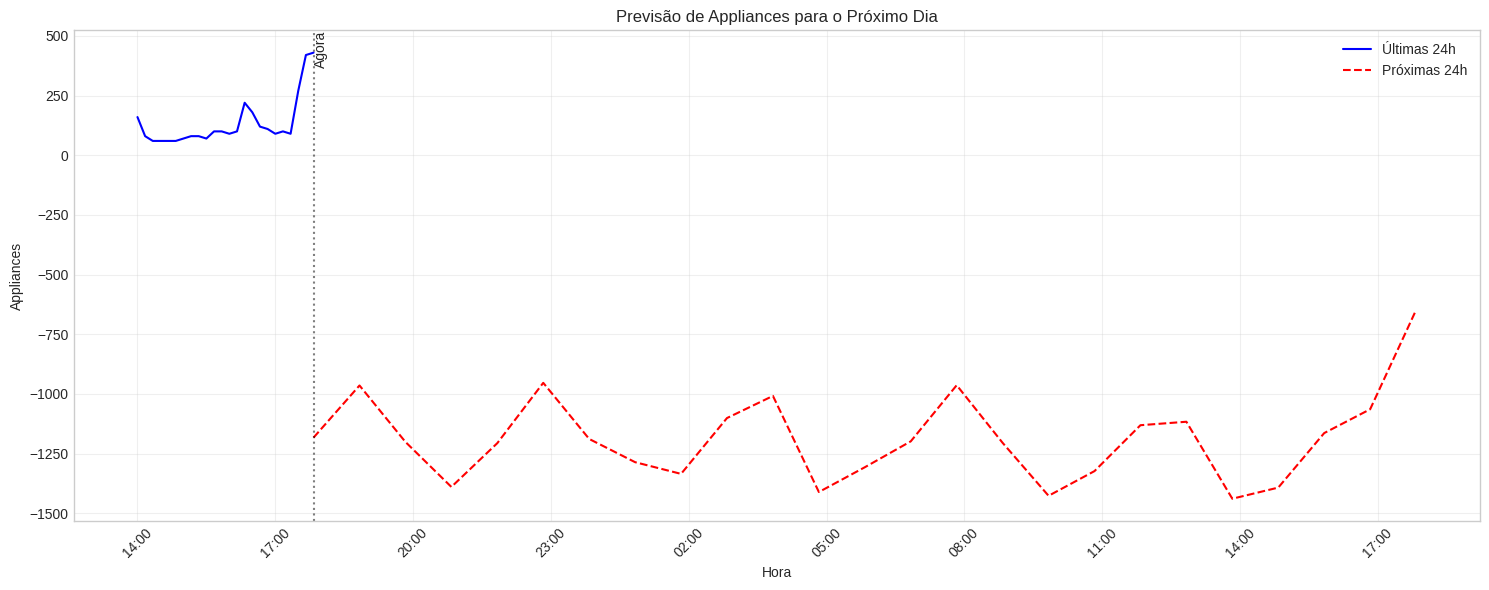


Previsões para as próximas 24 horas:
18:00: -1183.06
19:00: -964.82
20:00: -1201.37
21:00: -1389.95
22:00: -1206.41
23:00: -953.72
00:00: -1188.92
01:00: -1286.24
02:00: -1335.23
03:00: -1101.24
04:00: -1008.51
05:00: -1411.29
06:00: -1307.42
07:00: -1198.89
08:00: -963.69
09:00: -1205.24
10:00: -1427.08
11:00: -1323.56
12:00: -1131.29
13:00: -1116.76
14:00: -1439.32
15:00: -1392.70
16:00: -1164.27
17:00: -1064.49
18:00: -648.72


In [231]:
previsoes = fazer_previsoes_futuras(
    model=model,
    df=df,
    features=features,
    X_scaler=X_scaler,
    y_scaler=y_scaler,
    target='Appliances'  # ou o nome da sua coluna alvo
)
